##### Social Media Analytics
### Introduction to Text Mining
## Frequency Analysis
(c) Nuno Antonio 2019-2022 v1.02

### Initial setup

In [1]:
# Import packages
import csv
import pandas as pd
import numpy as np
import nltk 
import re
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns

In [23]:
# Load dataset
dtypes = {'RevID':'category','Source':'category','HotelID':'category',
  'HotelType':'category','HotelStars':'category','ObsDateGlobalRating':'float64',
  'Lanbguage':'category','RevUserName':'category','RevUserLocation':'category','RevOverallRating':'float64'}
ds = pd.DataFrame(pd.read_csv("HotelOnlineReviews.txt",sep="|", 
  error_bad_lines=False, dtype=dtypes, decimal=',', index_col='RevID'))

C:\Users\User\AppData\Local\Temp\ipykernel_7864\3634391456.py:5: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  ds = pd.DataFrame(pd.read_csv("HotelOnlineReviews.txt",sep="|",
Skipping line 12799: expected 21 fields, saw 23

Skipping line 37247: expected 21 fields, saw 22



In [24]:
ds.head()

,Source,HotelID,HotelType,HotelStars,HotelRooms,ObsDate,ObsDateTotalReviewsOnSite,ObsDateGlobalRating,RevDescription,Language,RevUsername,RevUserLocation,RevPublishedDate,RevOverallRating,RevLocationRating,RevSleepQualityRating,RevRoomsRating,RevServiceRating,RevValueRating,RevCleanlinessRating
RevID,,,,,,,,,,,,,,,,,,,,
B377,Booking,1,Resort,4,158,2015-11-29,1092,8.8,Hotel is so centrally located with bars and...,English,John,Ireland,2015-11-12,10.0,-1,-1,-1,-1,-1,-1
B378,Booking,1,Resort,4,158,2015-11-29,1092,8.8,Room were big & comfortable.þ Very noisy at ni...,English,David,United Kingdom,2015-11-09,5.8,-1,-1,-1,-1,-1,-1
B379,Booking,1,Resort,4,158,2015-11-29,1092,8.8,right near the beach & breakfast good!þ Noisy ...,English,Dawn,Portugal,2015-11-07,7.5,-1,-1,-1,-1,-1,-1
B380,Booking,1,Resort,4,158,2015-11-29,1092,8.8,"The location is the best in Portimao, just acr...",English,Ron,USA,2015-10-29,9.2,-1,-1,-1,-1,-1,-1
B381,Booking,1,Resort,4,158,2015-11-29,1092,8.8,Hotel was clean and the staff helpful and frie...,English,Pat,Spain,2015-10-27,7.1,-1,-1,-1,-1,-1,-1


In [25]:
# Drop non-Portuguese reviews
ds = ds.drop(ds[ds.Language!='Portuguese'].index)

In [26]:
ds.head()

,Source,HotelID,HotelType,HotelStars,HotelRooms,ObsDate,ObsDateTotalReviewsOnSite,ObsDateGlobalRating,RevDescription,Language,RevUsername,RevUserLocation,RevPublishedDate,RevOverallRating,RevLocationRating,RevSleepQualityRating,RevRoomsRating,RevServiceRating,RevValueRating,RevCleanlinessRating
RevID,,,,,,,,,,,,,,,,,,,,
B778,Booking,1,Resort,4,158,2015-11-29,1092,8.8,O Hotel está excelentemente localizado. A deco...,Portuguese,Anabela,Portugal,2015-10-08,9.2,-1,-1,-1,-1,-1,-1
B779,Booking,1,Resort,4,158,2015-11-29,1092,8.8,Localização e preçoþ Do sistema de protecção d...,Portuguese,Josefina,Portugal,2015-10-08,7.9,-1,-1,-1,-1,-1,-1
B780,Booking,1,Resort,4,158,2015-11-29,1092,8.8,"Hotel perfeito! Café da manhã excelente, equip...",Portuguese,Wendy,Brasil,2015-10-07,10.0,-1,-1,-1,-1,-1,-1
B781,Booking,1,Resort,4,158,2015-11-29,1092,8.8,Localização xelente frente à praia Qualidade...,Portuguese,Francisco,Portugal,2015-10-03,9.6,-1,-1,-1,-1,-1,-1
B782,Booking,1,Resort,4,158,2015-11-29,1092,8.8,Ótima localização!þ,Portuguese,Mariane,Brasil,2015-10-01,10.0,-1,-1,-1,-1,-1,-1


### Functions

In [2]:
# Text preprocessing
def textPreProcess(rawText, removeHTML=True, charsToRemove = r'\?|\.|\!|\;|\.|\"|\,|\(|\)|\&|\:|\-', removeNumbers=True, removeLineBreaks=False, specialCharsToRemove = r'[^\x00-\xfd]', convertToLower=True, removeConsecutiveSpaces=True):
    if type(rawText) != str:
        return rawText
    procText = rawText
        
    # Remove HTML
    if removeHTML:
        procText = BeautifulSoup(procText,'html.parser').get_text()

    # Remove punctuation and other special characters
    if len(charsToRemove)>0:
        procText = re.sub(charsToRemove,' ',procText)

    # Remove numbers
    if removeNumbers:
        procText = re.sub(r'\d+',' ',procText)

    # Remove line breaks
    if removeLineBreaks:
        procText = procText.replace('\n',' ').replace('\r', '')

    # Remove special characters
    if len(specialCharsToRemove)>0:
        procText = re.sub(specialCharsToRemove,' ',procText)

    # Normalize to lower case
    if convertToLower:
        procText = procText.lower() 

    # Replace multiple consecutive spaces with just one space
    if removeConsecutiveSpaces:
        procText = re.sub(' +', ' ', procText)
        
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(procText)
    filtered_text = [word for word in word_tokens if word.casefold() not in stop_words]
    procText = ' '.join(filtered_text)

    return procText

In [3]:
# Tokenize words
def tokenize_words(words):
    if (type(words) != str) or (word_tokenize(words) == ''):
        return np.nan
    else:
        return word_tokenize(words)

In [4]:
# Stemm texts
# aims to reduce words to their base or root form, known as the "stem." 
# WHAT IS SNOWBALL STEM?
# The Snowball stemmer in NLTK is based on the Snowball stemming algorithm
# different languages, such as English, French, Spanish, German, and many more. 
# Each language has its specific stemmer implementation within the Snowball stemmer.
def stemming(words):
    stemmed_word = [snowball.stem(x) for x in (words[:])]
    return stemmed_word

In [5]:
# Function to count the frequency of n-grams (Adapted from https://medium.com/analytics-vidhya/automated-keyword-extraction-from-articles-using-nlp-bfd864f41b34)
# Uses CountVectorizer from sklearn instead of FreqDist from NLTK
def get_top_n_words(corpus, n=None, nGrams=1): 
    vec = CountVectorizer(max_df=0.8, stop_words=stop_words,ngram_range=(nGrams,nGrams), max_features=10000).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

# max_df=0.8: Specifies that words occurring in more than 80% of the documents should be ignored.
# stop_words=stop_words: Excludes commonly used stop words from the analysis. The stop_words variable is assumed to be defined earlier.
# ? ngram_range=(nGrams, nGrams): Sets the range of n-grams to consider. In this case, it is set to the value of nGrams parameter.

### Analysis

In [6]:
# Create a dataframe with only the description
processedReviews =  pd.DataFrame(data=ds.RevDescription.apply(textPreProcess).values, index=ds.index, columns=['PreProcessedText']) 

NameError: name 'ds' is not defined

In [ ]:
processedReviews.head()

In [33]:
# Tokenize text
processedReviews['Words'] =  processedReviews['PreProcessedText'].apply(tokenize_words)

In [36]:
# Compute terms frequency distribution
from nltk.probability import FreqDist
fdist = FreqDist()
for review in processedReviews.Words:
  for term in review:
    fdist[term]+=1
    
# The code loops over each review in the processedReviews.Words object. 
# It assumes that processedReviews is a DataFrame
# Words is a column or attribute that represents the tokenized words for each review.
# For each review, the code loops over each term in the review. 
# It assumes that review is a list of tokenized words representing a single review.
# For each term encountered, the code increments its count in the fdist object by using the += operator. 
# This step accumulates the frequency count of each term as it appears across all the reviews.

In [37]:
# Transform results to a sorted dataframe
df_fdist = pd.DataFrame.from_dict(fdist, orient='index')
df_fdist.columns = ['Frequency']
df_fdist.index.name = 'Term'
df_fdist = df_fdist.sort_values(by='Frequency', ascending=False)

In [38]:
# Top 15
df_fdist.head(15)

,Frequency
Term,
e,13788
de,12375
a,10322
o,10169
do,6288
da,6145
muito,5796
que,5581
hotel,5284


In [39]:
# Low 15
df_fdist.tail(15)

,Frequency
Term,
orla,1
denotavam,1
impacientes,1
cumpriram,1
braços,1
entrasse,1
decia,1
agachado,1
viga,1


In [41]:
# Remove stopwords and re-explore results
from nltk.corpus import stopwords
stop_words = set(stopwords.words('portuguese'))
df_fdist = df_fdist[~df_fdist.index.isin(stop_words)]
df_fdist.head(15)

,Frequency
Term,
hotel,5284
quarto,4196
localização,3152
quartos,2347
pequeno,2307
bom,2235
excelente,2164
café,2101
bem,2009


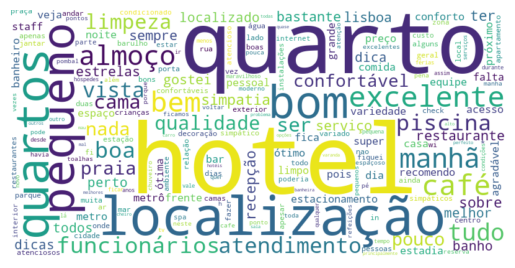

In [15]:
# Create a Word Cloud
import matplotlib.pyplot as plt
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white', contour_color='white')
wordcloud.generate_from_frequencies(frequencies=df_fdist.Frequency)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


The word cloud shows some words have the same origin, such as "quarto" and "quartos". Let's create a stemmed version of the word cloud

In [16]:
# Create a stemmed version of the words to normalize the Lexicon
# Import package
from nltk.stem import SnowballStemmer

In [17]:
# Check languages supported
print(" ".join(SnowballStemmer.languages))

arabic danish dutch english finnish french german hungarian italian norwegian porter portuguese romanian russian spanish swedish


In [18]:
# Do stemming
snowball = SnowballStemmer("portuguese")
# Create a new column for stemm words
processedReviews['StemmedWords'] = processedReviews['Words'].apply(stemming) 

In [19]:
# Calculate frequency distributions of the stemmed words
fdist = FreqDist()
for review in processedReviews.StemmedWords:
  for term in review:
    fdist[term]+=1

# Create the sorted dataframe and sort it
df_fdist = pd.DataFrame.from_dict(fdist, orient='index')
df_fdist.columns = ['Frequency']
df_fdist.index.name = 'Term'
df_fdist = df_fdist.sort_values(by='Frequency', ascending=False)

In [20]:
# Remove the stopwords
df_fdist = df_fdist[~df_fdist.index.isin(stop_words)] 

(-0.5, 799.5, 399.5, -0.5)

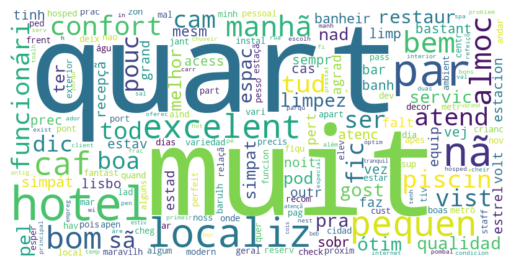

In [21]:
# Plot a new wordcloud with the stemmed words
wordcloud = WordCloud(width=800, height=400, background_color='white', contour_color='white')
wordcloud.generate_from_frequencies(frequencies=df_fdist.Frequency)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")

The word cloud is now different. For example, "Quart" (room) is now more frequent than "hotel".

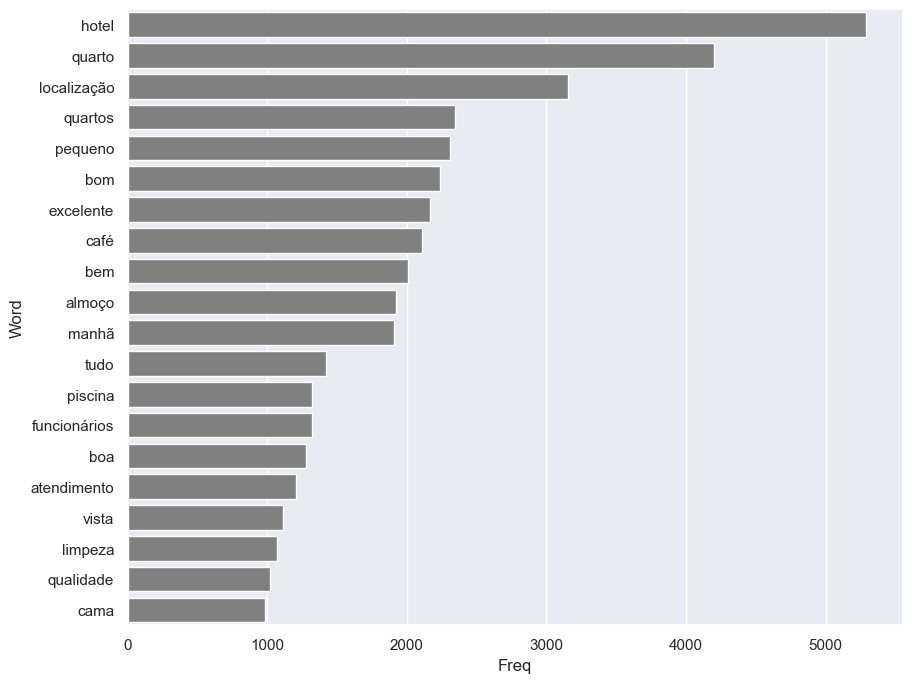

In [22]:
# PLOT top 20 most frequently occuring UNI-GRAMS
top_words = get_top_n_words(processedReviews['PreProcessedText'], n=20, nGrams=1)
top_df = pd.DataFrame(top_words)
top_df.columns=["Word", "Freq"]
sns.set(rc={'figure.figsize':(10,8)})
g = sns.barplot(data=top_df, x="Freq", y="Word", color="grey")

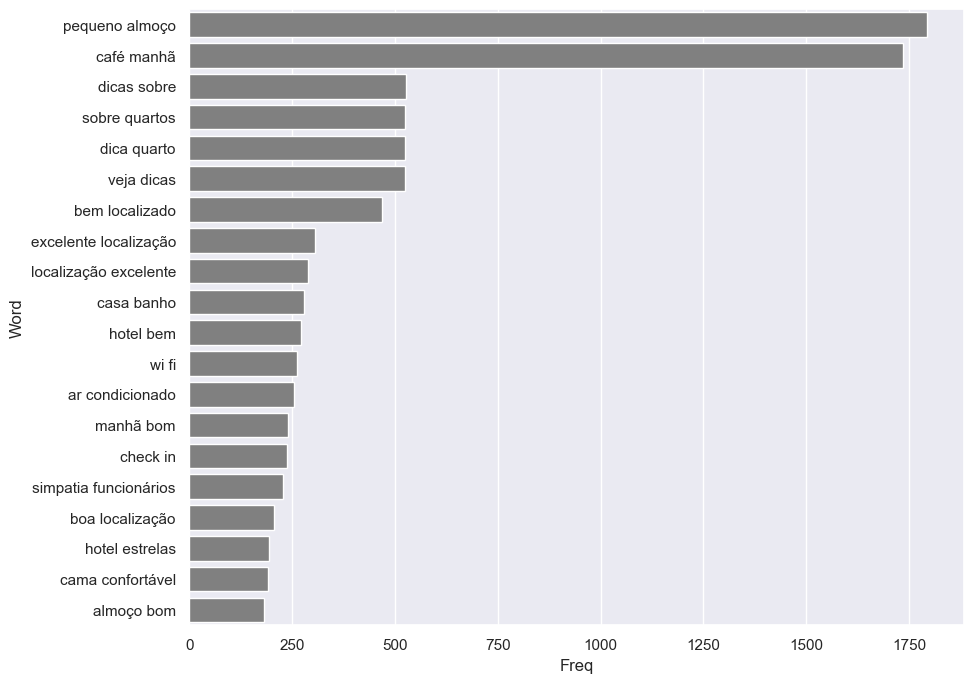

In [23]:
# PLOT top 20 most frequently occuring BI-GRAMS
top_words = get_top_n_words(processedReviews['PreProcessedText'], n=20, nGrams=2)
top_df = pd.DataFrame(top_words)
top_df.columns=["Word", "Freq"]
sns.set(rc={'figure.figsize':(10,8)})
g = sns.barplot(data=top_df, x="Freq", y="Word", color="grey")

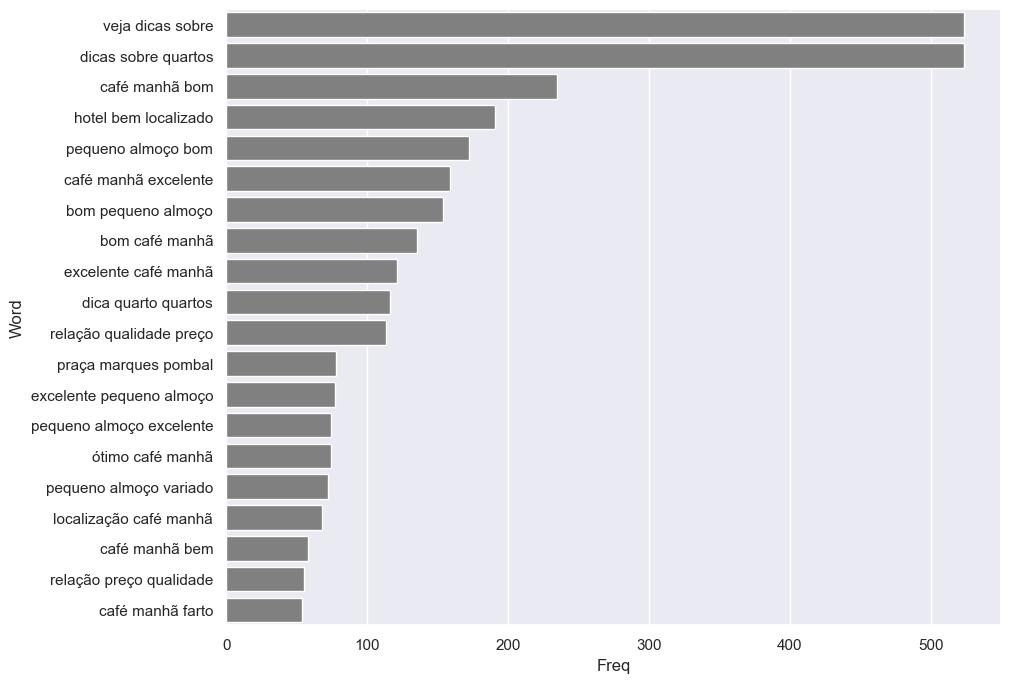

In [24]:
# PLOT top 20 most frequently occuring TRI-GRAMS
top_words = get_top_n_words(processedReviews['PreProcessedText'], n=20, nGrams=3)
top_df = pd.DataFrame(top_words)
top_df.columns=["Word", "Freq"]
sns.set(rc={'figure.figsize':(10,8)})
g = sns.barplot(data=top_df, x="Freq", y="Word", color="grey")

"Veja dicas sobre" and "dicas sobre quartos" is text added to the desciption by Tripadvisor to lead users to read more about the hotel. Therefore, this text should be removed from the description in the preprocessing phase.